In [10]:
import itertools
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import functools 
from itertools import product
import sys
sys.path.append('../Environments/')
from ColoredGridWorld import SetUpInferenceSpace as setUp
from ColoredGridWorld.MDP import MDP
from ColoredGridWorld import OBMDP
from ColoredGridWorld import visualizations
sys.path.append('../Algorithms/')
from ActionInterpretation import ActionInterpretation
from ValueIteration import ValueIteration
from DictValueIteration import ValueIteration as DictValueIteration
import pprint
import copy

In [11]:
def getJointTrajectory(jointState, policyTable, goal, jointTransitionFn, returnJointTraj = False):
    objectLevelTraj = [jointState[0]]
    jointTraj = [jointState]
    while(jointState[0]!=goal):
        action = max(policyTable[jointState], key=policyTable[jointState].get)
        jointState = max(jointTransitionFn(jointState, action), key = jointTransitionFn(jointState, action).get)
        objectLevelTraj.append(jointState[0])
        jointTraj.append(jointState)
    if(returnJointTraj): 
        return jointTraj
    else: 
        return objectLevelTraj

In [15]:
dimensions = (5,6)
goals = [(5,2)]
goalState = (5,2)
actions = {(-1,0),(0,1),(0,-1),(1,0)}
goalNameDictionary = {(5,2):'goal'}
colourReward = {'white': 0, 'orange': 0, 'purple': 0, 'blue':-2, 'yellow':10}
stateSpace = {(0,0): 'white',(0,1): 'white',(0,2): 'white',(0,3): 'white',(0,4): 'white', (1,0): 'blue',(1,1): 'orange', (1,2):'orange',(1,3):'orange',(1,4):'orange', (2,0): 'blue',(2,1):'purple', (2,2):'purple', (2,3):'purple', (2,4):'orange', (3,0): 'blue',(3,1):'purple',(3,2): 'blue',(3,3):'purple',(3,4):'orange', (4,0): 'blue', (4,1): 'blue', (4,2): 'blue',(4,3):'purple', (4,4):'orange', (5,0):'white',(5,1):'white', (5,2):'yellow', (5,3):'white', (5,4):'white'}
getMDP = MDP(dimensions, stateSpace, colourReward)
objectRewardFn, objectTransitionFn = getMDP()

#set up for value-iteration and inference
convergenceTolerance = 10e-6
gamma = 0.95
alpha = 20
eps = 0.05
hyperparameters = (convergenceTolerance, gamma, alpha, eps)
variableColours = ['orange', 'purple', 'blue']
variableReward = [0, -2]
constantRewardDict = {'white': 0, 'yellow': 10}


utilitySpace = setUp.buildUtilitySpace(variableColours, variableReward, constantRewardDict)
transitionSpace = [True]
worlds = setUp.buildWorldSpace(utilitySpace, transitionSpace)
envSpace = [(world, goal) for world, goal in product(worlds, goals)]
envMDPsAndPolicies = setUp.buildEnvPolicySpace(dimensions, stateSpace, actions, envSpace, hyperparameters)
actionInterpretation = ActionInterpretation(envMDPsAndPolicies)

#set up for OBMDP and its value iteration 
beta = 10
beliefGamma = 0.95
beliefAlpha = 20
beliefEps = 0.05
#bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.25,0.5,0.75,1]
beliefSpacePossible = [{key:value for key, value in zip(envSpace, permutations)} for permutations in product(bins, repeat = len(envSpace))]
discreteBeliefSpace = [beliefDict for beliefDict in beliefSpacePossible if (sum(value for value in beliefDict.values())==1)]
hashableDiscreteBeliefSpace = [setUp.HashableBelief(beliefDict) for beliefDict in discreteBeliefSpace]
uniformPriorBelief = setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               })
hashableDiscreteBeliefSpace.append(uniformPriorBelief)
beliefUtilityFn = OBMDP.getBeliefUtility()
literalObserver = OBMDP.LiteralObserver(actionInterpretation)
getNextBelief = literalObserver(discreteBeliefSpace, True)
jointStateSpace = list(product(stateSpace.keys(), hashableDiscreteBeliefSpace))
getOBMDP = OBMDP.OBMDP((setUp.HashableWorld(colourReward, True), goals[0]), True, beta)
jointRewardFn, jointTransitionFn = getOBMDP(objectTransitionFn, objectRewardFn, getNextBelief, beliefUtilityFn)
#print(len(hashableDiscreteBeliefSpace))
#print(len(jointStateSpace))

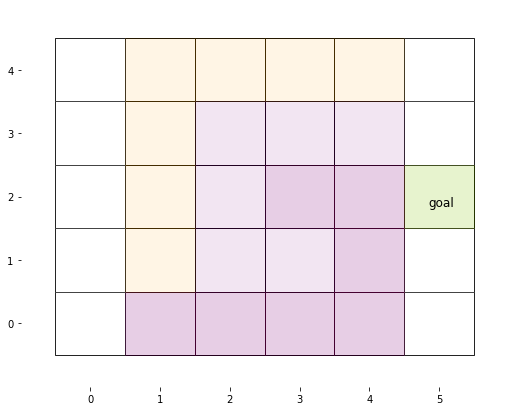

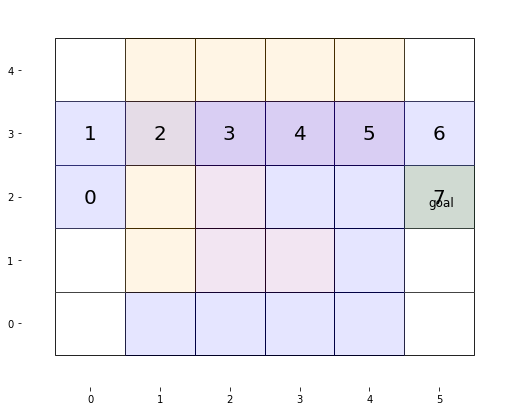

In [16]:
#implementing object-level MDP
valueTable = {key: 0 for key in stateSpace.keys()}
performValueIteration = ValueIteration(actions, objectTransitionFn, objectRewardFn, valueTable, [goalState], convergenceTolerance, gamma, alpha, eps, True)
optimalValues, policyTable = performValueIteration()
trapStates = [s for s in stateSpace if(colourReward[stateSpace[s]]<0)]
n,m = dimensions 
visualizations.visualizeEnvironmentByState(stateSpace,[goalState], trapStates, [], goalNameDictionary, 1.75)

s = (0,2)
traj = [s]
while(s!=goalState):
    action = max(policyTable[s], key=policyTable[s].get)
    s = max(objectTransitionFn(s,action), key = objectTransitionFn(s,action).get)
    traj.append(s)
visualizations.visualizeEnvironmentByState(stateSpace, [goalState], [], traj, goalNameDictionary, 1.75)

In [17]:
#implementing OBMDP
jointTransitionDict = {jointState:{action:jointTransitionFn(jointState, action) for action in actions} for jointState in jointStateSpace if jointState[0]!=goalState}
print("transitionDict done")

transitionDict done


In [18]:
jointRewardDict = copy.deepcopy(jointTransitionDict)
for jointState, actionAndNextStateDict in jointRewardDict.items():
    for action, nextJointStateAndProb in actionAndNextStateDict.items():
        for nextJointState in nextJointStateAndProb.keys():
            jointRewardDict[jointState][action][nextJointState] = jointRewardFn(jointState, action, nextJointState)
print("rewardDict done")

rewardDict done


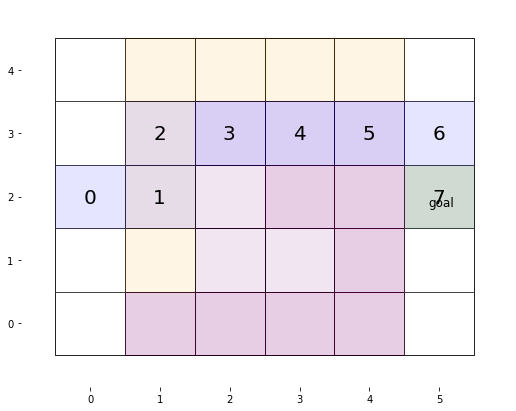

In [19]:
valueTable = {key: 0 for key in jointStateSpace}
jointGoalStates = [jointState for jointState in jointStateSpace if jointState[0] == goalState]
performValueIteration = DictValueIteration(jointTransitionDict, jointRewardDict, valueTable, jointGoalStates, convergenceTolerance, beliefGamma, beliefAlpha, beliefEps)
optimalValues, policyTable = performValueIteration()
initialState1 = ( (0,2), setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               }) )

jointTraj = getJointTrajectory(initialState1, policyTable, goalState, jointTransitionFn, True)
objectLevelTraj = getJointTrajectory(initialState1, policyTable, goalState, jointTransitionFn)
#viewPolicyStructure(policyTable, ["state", "action", "probability"])
#visualizations.visualizeEnvironmentByState(stateSpace,[goalState], [], [], goalNameDictionary, 1.75)
visualizations.visualizeEnvironmentByState(stateSpace, [goalState], trapStates, objectLevelTraj, goalNameDictionary, 1.75)

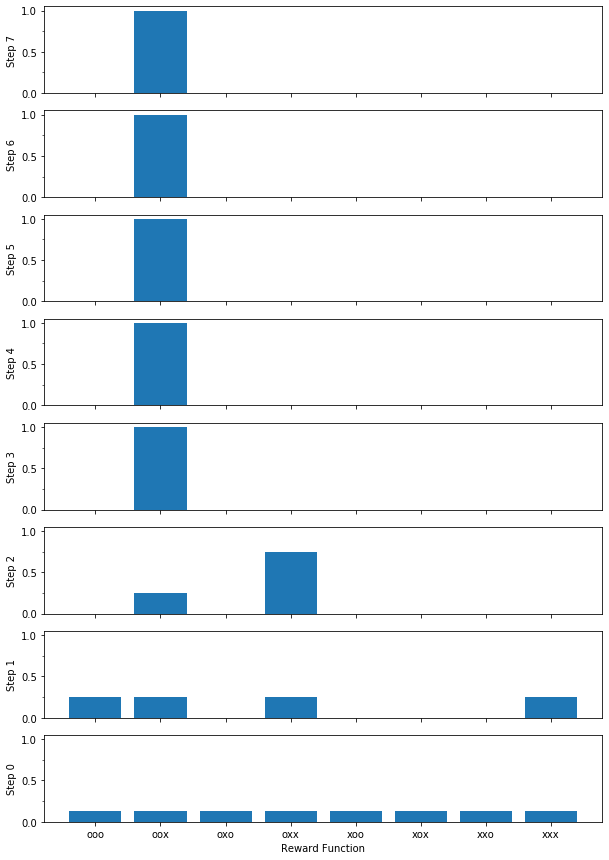

In [20]:
orderOfColours = ["orange", "purple", "blue"]
visualizations.beliefStateInTrajectoryGraph(jointTraj, orderOfColours, (10,15))